In [1]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve, get_scorer_names
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ICU.csv')
df = df.drop(columns=df.columns[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         200 non-null    int64
 1   Survive    200 non-null    int64
 2   Age        200 non-null    int64
 3   AgeGroup   200 non-null    int64
 4   Sex        200 non-null    int64
 5   Infection  200 non-null    int64
 6   SysBP      200 non-null    int64
 7   Pulse      200 non-null    int64
 8   Emergency  200 non-null    int64
dtypes: int64(9)
memory usage: 14.2 KB


In [3]:
df.shape
#Shape of dataset is (200,9)

(200, 9)

### Exploratory Data Analysis

In [4]:
df.head(n=10)

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1
5,28,1,54,2,0,1,142,103,1
6,32,1,87,3,1,1,110,154,1
7,38,1,69,2,0,1,110,132,1
8,40,1,63,2,0,0,104,66,0
9,41,1,30,1,1,0,144,110,1


Here we see 'Survive' will be our dependent variable as the other variables will be treated as the predictor variables

In [5]:
df['ID'].nunique()
#Here we see that each of the patient in the dataset is unique (no. of unique id = no. of rows) 
#and thus has no duplicate rows

200

In [6]:
df.describe()

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,444.82000,0.800000,57.545000,2.025000,0.380000,0.420000,132.280000,98.92500,0.735000
std,271.91668,0.401004,20.054648,0.785788,0.486604,0.494797,32.952099,26.82962,0.442441
min,4.00000,0.000000,16.000000,1.000000,0.000000,0.000000,36.000000,39.00000,0.000000
25%,210.25000,1.000000,46.750000,1.000000,0.000000,0.000000,110.000000,80.00000,0.000000
50%,412.50000,1.000000,63.000000,2.000000,0.000000,0.000000,130.000000,96.00000,1.000000
75%,671.75000,1.000000,72.000000,3.000000,1.000000,1.000000,150.000000,118.25000,1.000000
max,929.00000,1.000000,92.000000,3.000000,1.000000,1.000000,256.000000,192.00000,1.000000


ID           0.135952
Survive     -1.511359
Age         -0.641351
AgeGroup    -0.044135
Sex          0.498196
Infection    0.326631
SysBP        0.298842
Pulse        0.414645
Emergency   -1.073019
dtype: float64


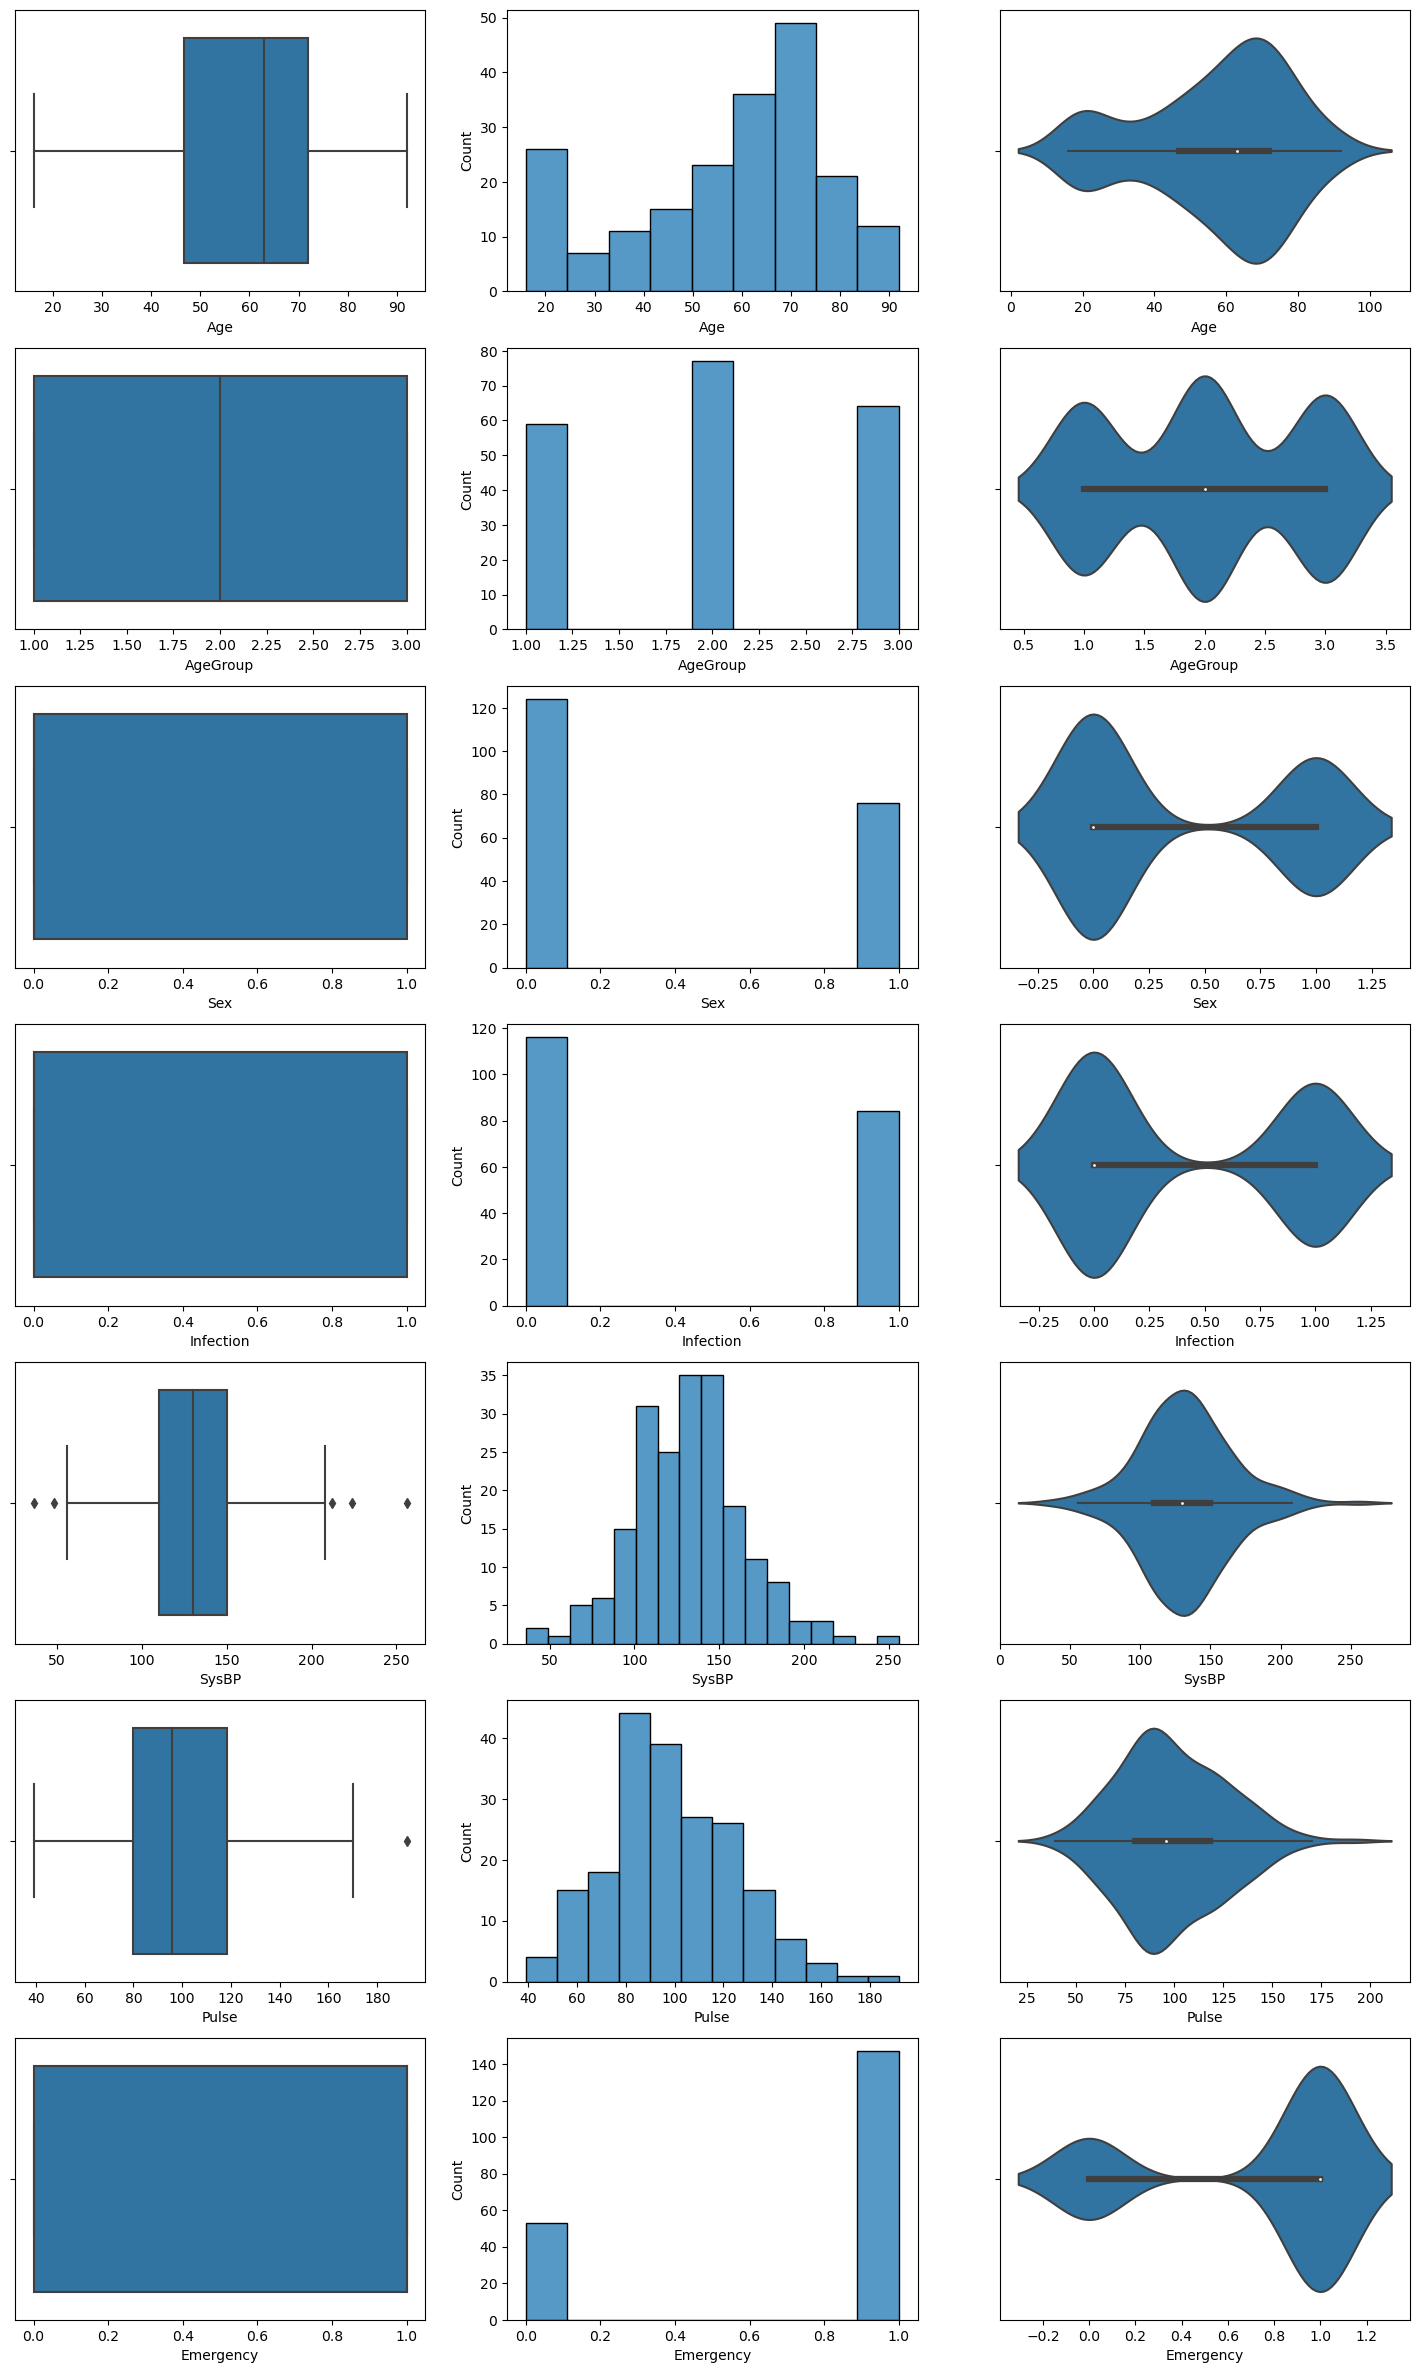

In [7]:
#Where ID are unique values and Survive is the dependent variable
col_to_analyse = df.drop(columns=['ID','Survive']).columns
count = 0
print(df.skew())
f, axes = plt.subplots(7, 3, figsize=(18, 30))
for var in df[col_to_analyse]:
    sns.boxplot(df[var], ax = axes[count,0])
    sns.histplot(df[var], ax = axes[count,1])
    sns.violinplot(df[var], orient = "h", ax = axes[count,2])
    count += 1

In the above we observe that factors: Sex, Infection and Emergency are binary variables <br>
AgeGroup has 3 classes <br>
The other classes are slightly skewed

1    160
0     40
Name: Survive, dtype: int64


<Axes: xlabel='Survive', ylabel='count'>

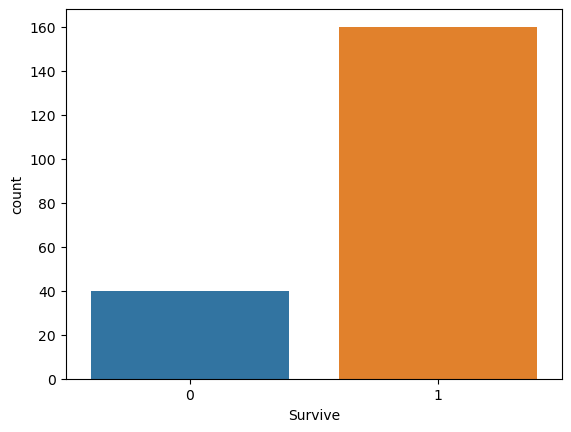

In [8]:
print(df['Survive'].value_counts())
sns.countplot(df['Survive'])

Here we see that the Survive rate is highly skewed and thus will require to use some methods to deal with this imbalance. We will look at StratifiedKfold as a possible method

<Axes: xlabel='AgeGroup', ylabel='count'>

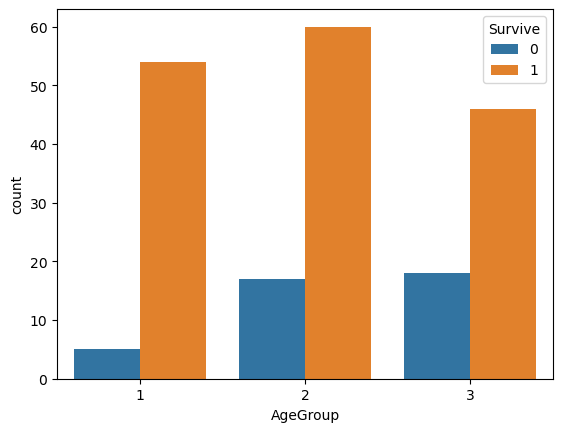

In [9]:
sns.countplot(df['AgeGroup'],hue=df['Survive'])

<Axes: >

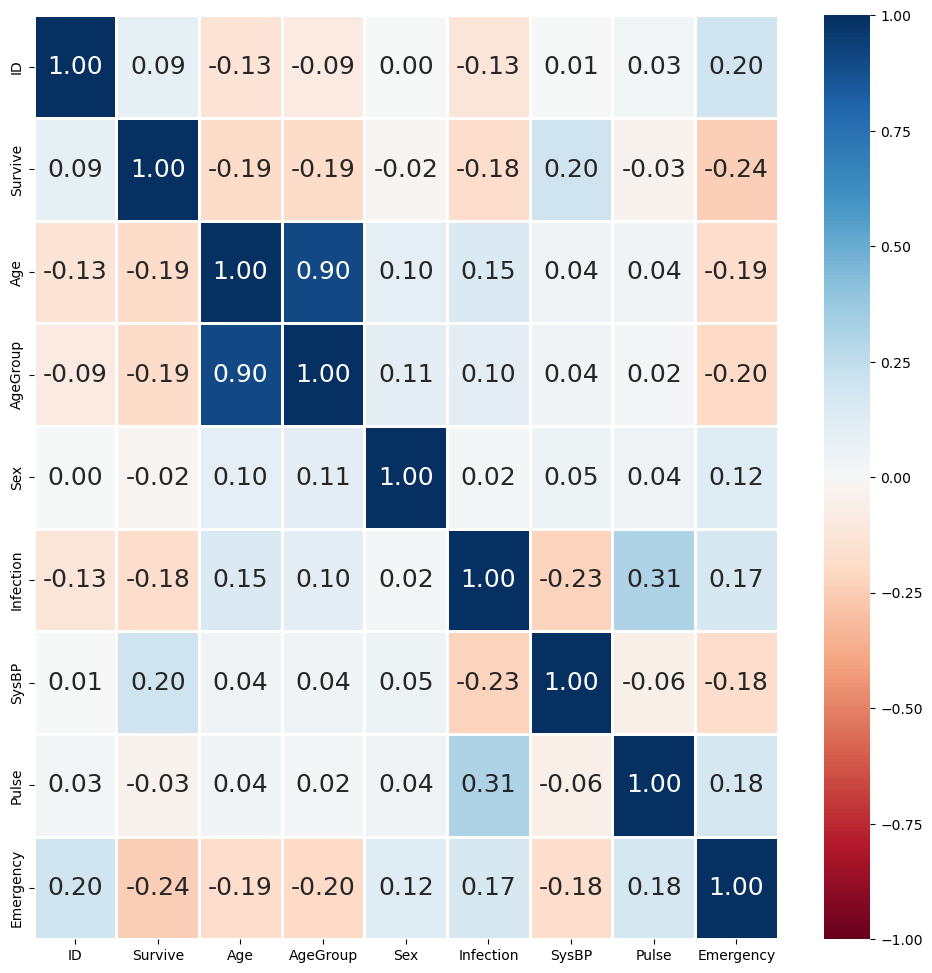

In [10]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

#### Feature Generation

Pulse/BP levels too high can mean that the patient is in distress which could be a factor for inability to survive
Create a new column with binary values where 1 if pulse/bp exceed healthy threshold levels and 0 if patient is within range
From references, if BP > 120 or Pulse > 100 is unhealthy.

1    159
0     41
Name: heart_cond, dtype: int64


<Axes: xlabel='heart_cond', ylabel='count'>

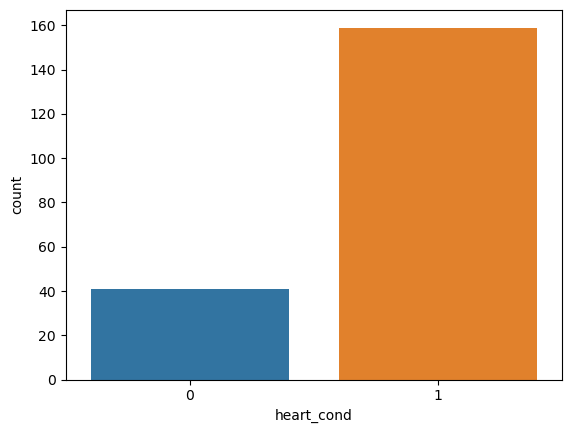

In [11]:
df['heart_cond'] = df[['SysBP','Pulse']].apply(lambda x: 1 if x['SysBP']>120 or x['Pulse']>100 else 0,axis=1)
print(df['heart_cond'].value_counts())
sns.countplot(df['heart_cond'])

We get the almost same distribution as 'Survive'

In [12]:
#We will drop our ID rows as our model should not use ID as a predictor
df = df.drop(columns='ID')
df_norm = copy.deepcopy(df)
df_norm['SysBP'] = df_norm['SysBP'] = ((df_norm['SysBP'] - df_norm['SysBP'].min()) / (df_norm['SysBP'].max() - df_norm['SysBP'].min()))
df_norm['Pulse'] = df_norm['Pulse'] = ((df_norm['Pulse'] - df_norm['Pulse'].min()) / (df_norm['Pulse'].max() - df_norm['Pulse'].min()))

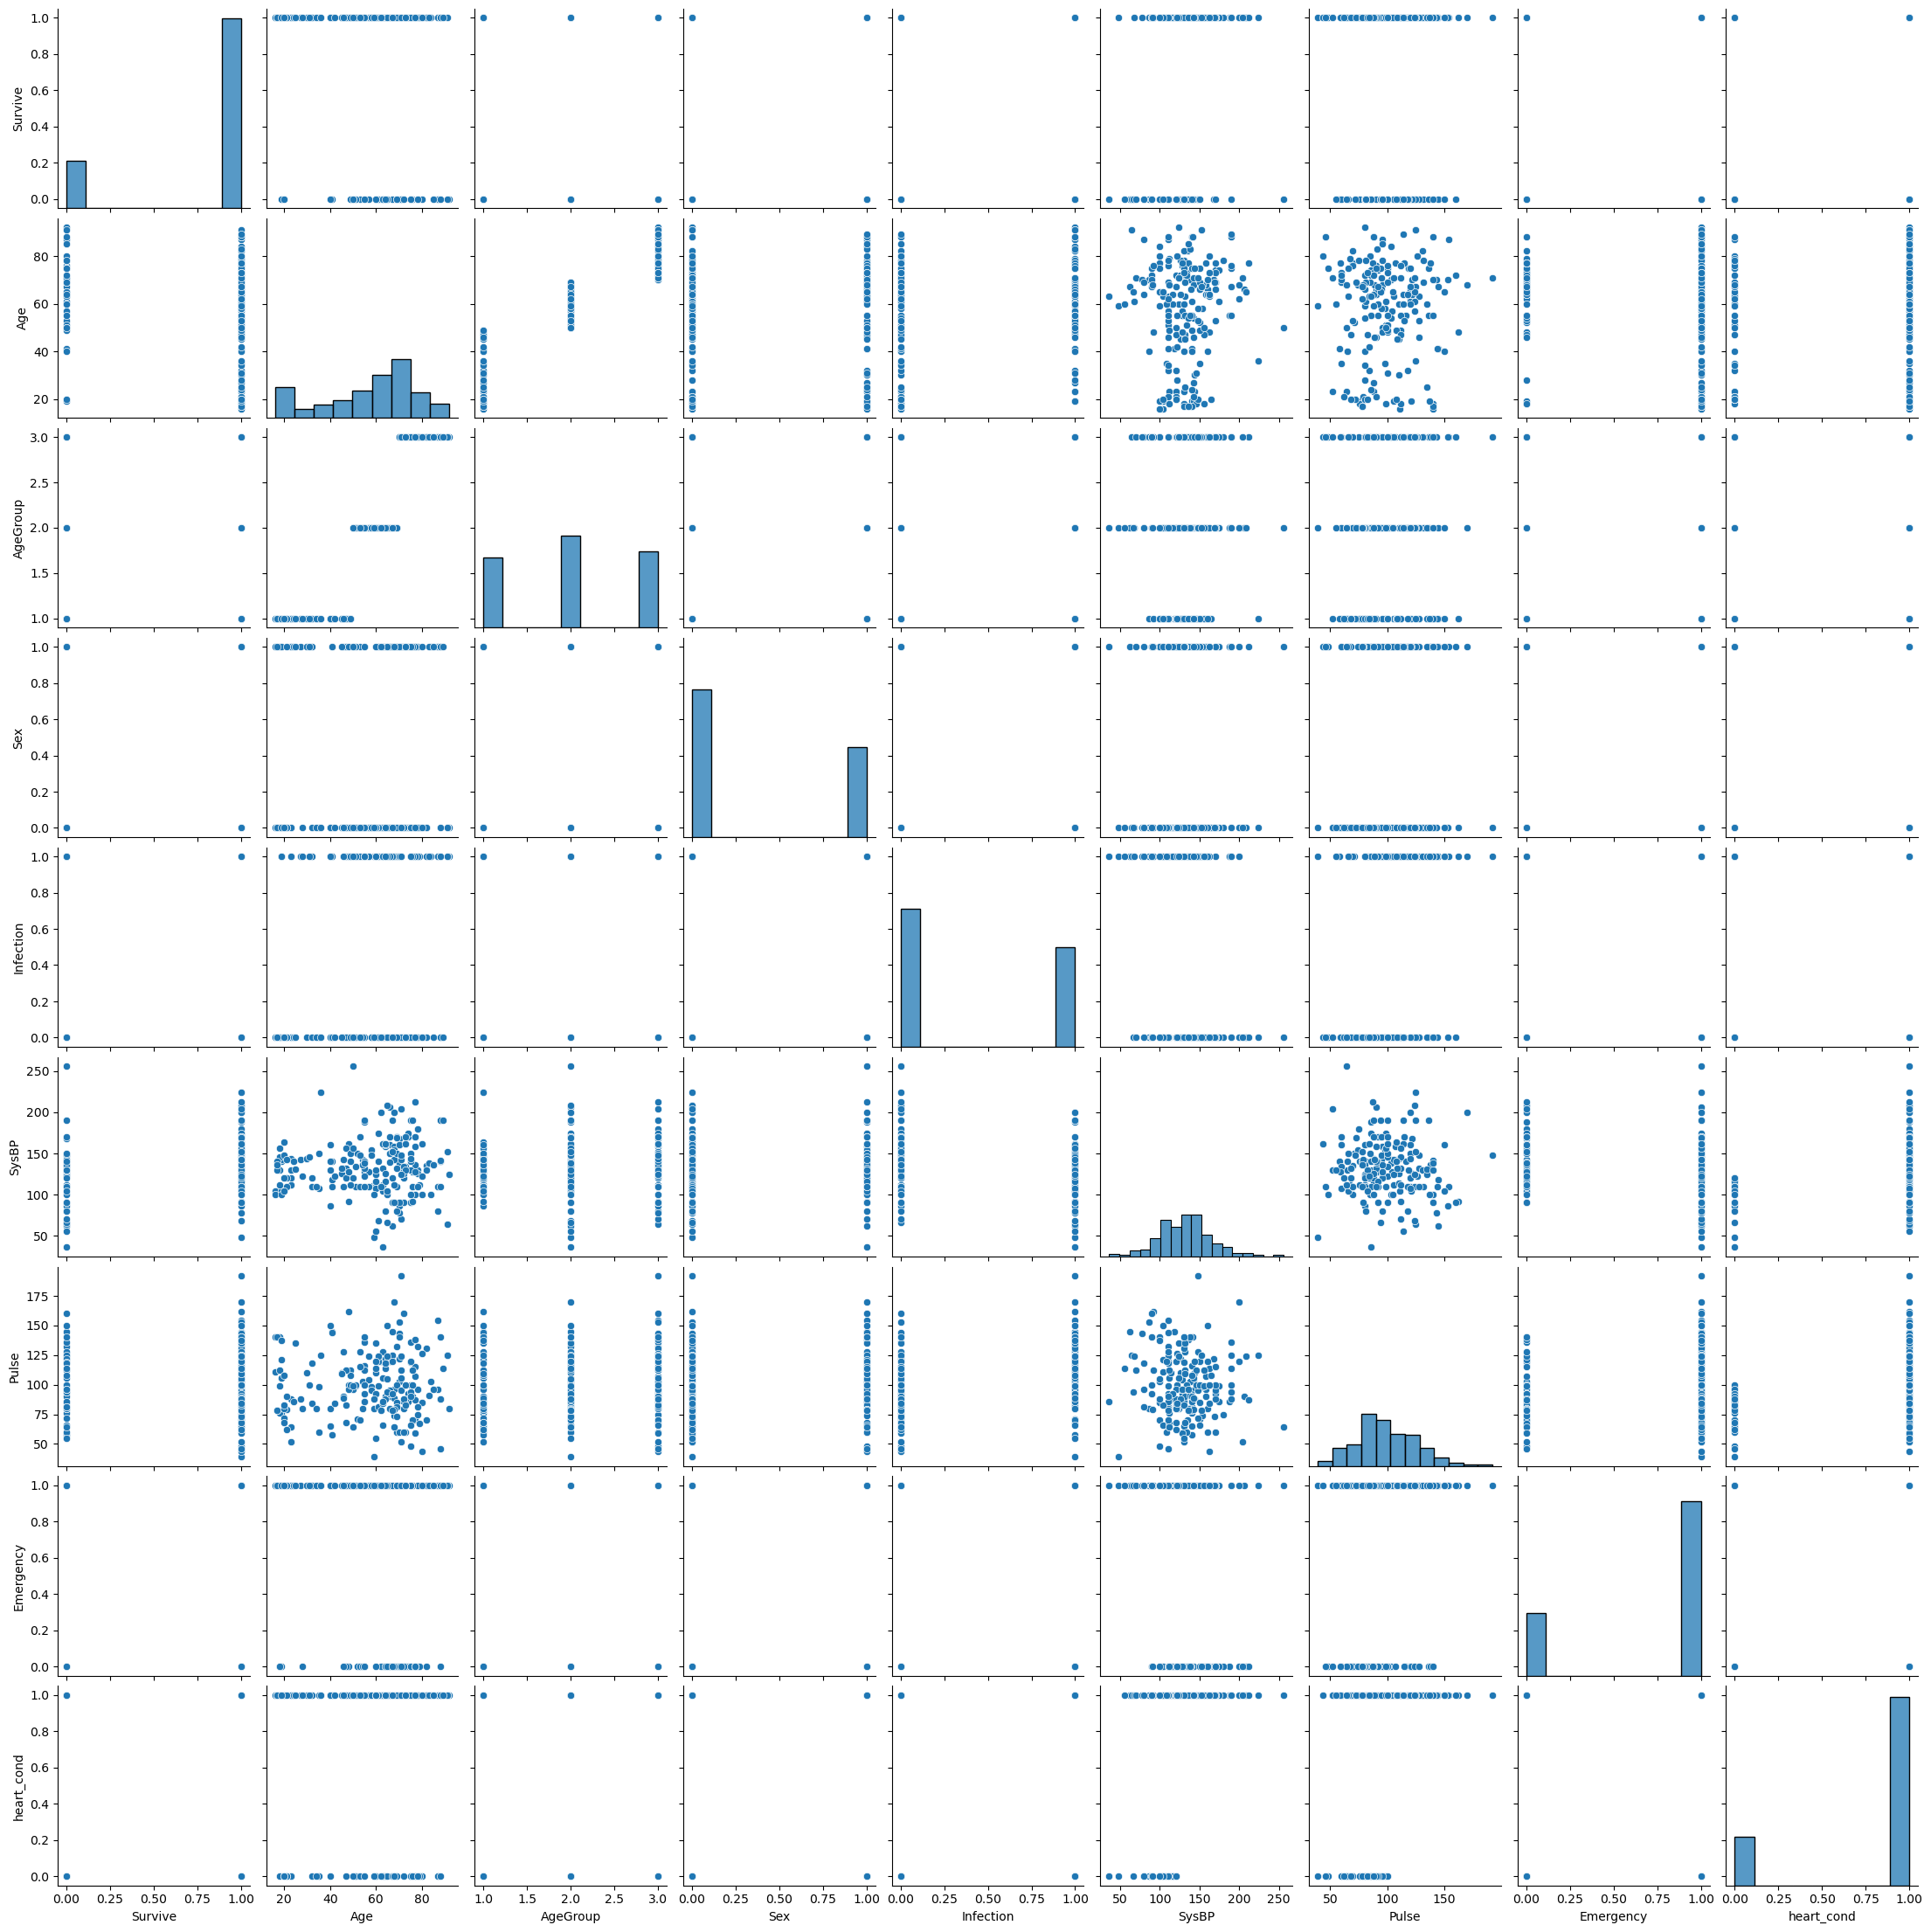

In [13]:
sns.pairplot(df)

### Modeling

#### Logsitic Regression

In [14]:
#Train test split to split data into training and test set for checking how well the model performs
#Use StratifiedKFold to deal with imbalanced data
df_train = df_norm.drop(columns='Survive')
df_test = df_norm['Survive']
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

##### Hyper parameter tuning for Logistic Regression

In [15]:
#Call the Logistic Regression Function for Tuning using GridSearchCV
clf_lr = LogisticRegression()

space= {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'penalty': ['none', 'l1', 'l2', 'elasticnet']
       }
search = GridSearchCV(clf_lr, space, scoring='roc_auc')
result = search.fit(df_train, df_test)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.75546875
Best Hyperparameters: {'C': 1e-05, 'penalty': 'none', 'solver': 'newton-cg'}


##### Running Model without stratifying data

In [16]:
clf_lr_tuned = LogisticRegression(C=1e-5,penalty='none',solver='newton-cg')
x, X, y, Y = train_test_split(df_train,df_test,random_state=1,test_size=0.2)
clf_lr_tuned.fit(x,y)
print('Score of Logistic Regression: ',clf_lr_tuned.score(X,Y))
print('Confusion matrix\n',confusion_matrix(Y,clf_lr_tuned.predict(X)))

Score of Logistic Regression:  0.675
Confusion matrix
 [[ 1 12]
 [ 1 26]]


##### Running Model with Stratified-K-fold to account for imbalance of data

In [17]:
lr_strat_fold_value = []
keep_best_score = 0
keep_best_reg = None
clf_lr_kftuned = LogisticRegression(C=1e-5,penalty='none',solver='newton-cg')
for train_idx, test_idx in kfold.split(df_train, df_test):
    x_train, x_test = df_train.loc[train_idx], df_train.loc[test_idx]
    y_train, y_test = df_test.loc[train_idx], df_test.loc[test_idx]
    
    clf_lr_kftuned.fit(x_train, y_train)
    
    if keep_best_reg is not None:
        if clf_lr_kftuned.score(x_test, y_test) > keep_best_score:
            keep_best_reg = copy.copy(clf_lr_kftuned)
            
    else:
        keep_best_reg = copy.copy(clf_lr_kftuned)
        keep_best_score = clf_lr_kftuned.score(x_test, y_test)
    
    lr_strat_fold_value.append(clf_lr_kftuned.score(x_test, y_test))

print('List of accuracies:', lr_strat_fold_value)
print('Best Accuracy Obtainable with these parameters:',
      max(lr_strat_fold_value)*100, '%')
print('Min Accuracy Obtainable with these parameters:',
      min(lr_strat_fold_value)*100, '%')
print('\nOverall Accuracy:',
      np.mean(lr_strat_fold_value)*100, '%')
print('\nStandard Deviation is:', np.std(lr_strat_fold_value))

List of accuracies: [0.8, 0.725, 0.725, 0.8, 0.8]
Best Accuracy Obtainable with these parameters: 80.0 %
Min Accuracy Obtainable with these parameters: 72.5 %

Overall Accuracy: 76.99999999999999 %

Standard Deviation is: 0.036742346141747706


In [18]:
print('Score of best Logistic Regression Model: ',keep_best_reg.score(x_test,y_test))
print('Confusion matrix\n',confusion_matrix(y_test,keep_best_reg.predict(x_test)))

Score of best Logistic Regression Model:  0.85
Confusion matrix
 [[ 2  6]
 [ 0 32]]


#### Decision Tree

In [19]:
param_space = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
clf_dt = DecisionTreeClassifier(random_state=1)
tree_search = GridSearchCV(estimator=clf_dt, param_grid=param_space, cv=5, verbose=True)
tree_result = tree_search.fit(df_train, df_test)
print('Best Score: %s' % tree_result.best_score_)
print('Best Hyperparameters: %s' % tree_result.best_params_)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best Score: 0.805
Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}


In [20]:
clf_dt_tuned = DecisionTreeClassifier(ccp_alpha=0.01,
                                      criterion='gini',
                                      max_depth=3,
                                      max_features='log2',
                                      random_state=1)
x, X, y, Y = train_test_split(df_train,df_test,random_state=1,test_size=0.2)
clf_dt_tuned.fit(x,y)
print('Score of Tree Classifier: ',clf_dt_tuned.score(X,Y))
print('Confusion matrix\n',confusion_matrix(Y,clf_dt_tuned.predict(X)))

Score of Tree Classifier:  0.75
Confusion matrix
 [[ 4  9]
 [ 1 26]]


In [21]:
dt_strat_fold_value = []
keep_best_score = 0
keep_best_tree = None
clf_dt_kftuned = DecisionTreeClassifier(ccp_alpha=0.01,
                                        criterion='gini',
                                        max_depth=3,
                                        max_features='log2',
                                        random_state=1)
for train_idx, test_idx in kfold.split(df_train, df_test):
    x_train, x_test = df_train.loc[train_idx], df_train.loc[test_idx]
    y_train, y_test = df_test.loc[train_idx], df_test.loc[test_idx]
    
    clf_dt_kftuned.fit(x_train, y_train)
    
    if keep_best_tree is not None:
        if clf_dt_kftuned.score(x_test, y_test) > keep_best_score:
            keep_best_tree = copy.copy(clf_dt_kftuned)
            
    else:
        keep_best_tree = copy.copy(clf_dt_kftuned)
        keep_best_score = clf_dt_kftuned.score(x_test, y_test)

    dt_strat_fold_value.append(clf_dt_kftuned.score(x_test, y_test))

print('List of accuracies:', dt_strat_fold_value)
print('Best Accuracy Obtainable with these parameters:',
      max(dt_strat_fold_value)*100, '%')
print('Min Accuracy Obtainable with these parameters:',
      min(dt_strat_fold_value)*100, '%')
print('\nOverall Accuracy:',
      np.mean(dt_strat_fold_value)*100, '%')
print('\nStandard Deviation is:', np.std(dt_strat_fold_value))

List of accuracies: [0.85, 0.85, 0.825, 0.725, 0.825]
Best Accuracy Obtainable with these parameters: 85.0 %
Min Accuracy Obtainable with these parameters: 72.5 %

Overall Accuracy: 81.5 %

Standard Deviation is: 0.04636809247747852


In [22]:
print('Score of best Stratified Tree Classifier: ',keep_best_tree.score(x_test,y_test))
print('Confusion matrix:\n',confusion_matrix(y_test,keep_best_tree.predict(x_test)))

Score of best Stratified Tree Classifier:  0.825
Confusion matrix:
 [[ 1  7]
 [ 0 32]]


##### Alternative: Inbuilt parameter - class_weight

In [23]:
clf_dt_tuned = DecisionTreeClassifier(ccp_alpha=0.01,
                                      criterion='gini',
                                      max_depth=3,
                                      max_features='log2',
                                      random_state=1, class_weight='balanced')
x, X, y, Y = train_test_split(df_train,df_test,random_state=1,test_size=0.2)
clf_dt_tuned.fit(x,y)
print('Score of Tree Classifier: ',clf_dt_tuned.score(X,Y))
print('Confusion matrix\n',confusion_matrix(Y,clf_dt_tuned.predict(X)))

Score of Tree Classifier:  0.5
Confusion matrix
 [[ 8  5]
 [15 12]]


#### Random Forest Classifier

In [24]:
param_grid = {'n_estimators': [10, 50, 100, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [2,3,4,5,6,7,8],
              'criterion' :['gini', 'entropy', 'log']}
clf_rf = RandomForestClassifier(random_state=1)
forest_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, verbose=True)
forest_result = forest_search.fit(df_train, df_test)
print('Best Score: %s' % forest_search.best_score_)
print('Best Hyperparameters: %s' % forest_result.best_params_)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best Score: 0.8099999999999999
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 200}


In [25]:
clf_rf_tuned = RandomForestClassifier(criterion='entropy',
                                      max_depth=3,
                                      max_features='log2',
                                      n_estimators=200,
                                      random_state=1)
x, X, y, Y = train_test_split(df_train,df_test,random_state=1,test_size=0.2)
clf_rf_tuned.fit(x,y)
print('Score of Forest Classifier: ',clf_rf_tuned.score(X,Y))
print('Confusion matrix\n',confusion_matrix(Y,clf_rf_tuned.predict(X)))

Score of Forest Classifier:  0.675
Confusion matrix
 [[ 1 12]
 [ 1 26]]


In [26]:
rf_strat_fold_value = []
keep_best_score = 0
keep_best_forest = None
clf_rf_kftuned = RandomForestClassifier(criterion='entropy',
                                        max_depth=3,
                                        max_features='log2',
                                        n_estimators=200,
                                        random_state=1)
for train_idx, test_idx in kfold.split(df_train, df_test):
    x_train, x_test = df_train.loc[train_idx], df_train.loc[test_idx]
    y_train, y_test = df_test.loc[train_idx], df_test.loc[test_idx]
    
    clf_rf_kftuned.fit(x_train, y_train)
    
    if keep_best_tree is not None:
        if clf_rf_kftuned.score(x_test, y_test) > keep_best_score:
            keep_best_forest = copy.copy(clf_rf_kftuned)
            
    else:
        keep_best_forest = copy.copy(clf_dt_kftuned)
        keep_best_score = clf_rf_kftuned.score(x_test, y_test)

    rf_strat_fold_value.append(clf_rf_kftuned.score(x_test, y_test))

print('List of accuracies:', rf_strat_fold_value)
print('Best Accuracy Obtainable with these parameters:',
      max(rf_strat_fold_value)*100, '%')
print('Min Accuracy Obtainable with these parameters:',
      min(dt_strat_fold_value)*100, '%')
print('\nOverall Accuracy:',
      np.mean(rf_strat_fold_value)*100, '%')
print('\nStandard Deviation is:', np.std(rf_strat_fold_value))

List of accuracies: [0.825, 0.8, 0.825, 0.8, 0.825]
Best Accuracy Obtainable with these parameters: 82.5 %
Min Accuracy Obtainable with these parameters: 72.5 %

Overall Accuracy: 81.5 %

Standard Deviation is: 0.012247448713915848


In [27]:
print('Score of Best Forest Classifier: ',keep_best_forest.score(x_test,y_test))
print('Confusion matrix\n',confusion_matrix(Y,keep_best_forest.predict(x_test)))

Score of Best Forest Classifier:  0.825
Confusion matrix
 [[ 1 12]
 [ 0 27]]


##### Alternative: Inbuilt parameter - class_weight

In [28]:
clf_rf_tuned_w = RandomForestClassifier(criterion='entropy',
                                      max_depth=3,
                                      max_features='log2',
                                      n_estimators=200,
                                      random_state=1, class_weight='balanced')
x, X, y, Y = train_test_split(df_train,df_test,random_state=1,test_size=0.2)
clf_rf_tuned.fit(x,y)
print('Score of Forest Classifier: ',clf_rf_tuned.score(X,Y))
print('Confusion matrix\n',confusion_matrix(Y,clf_rf_tuned.predict(X)))

Score of Forest Classifier:  0.675
Confusion matrix
 [[ 1 12]
 [ 1 26]]


### Compare Metrics

Text(0.5, 0, 'False positive rate')

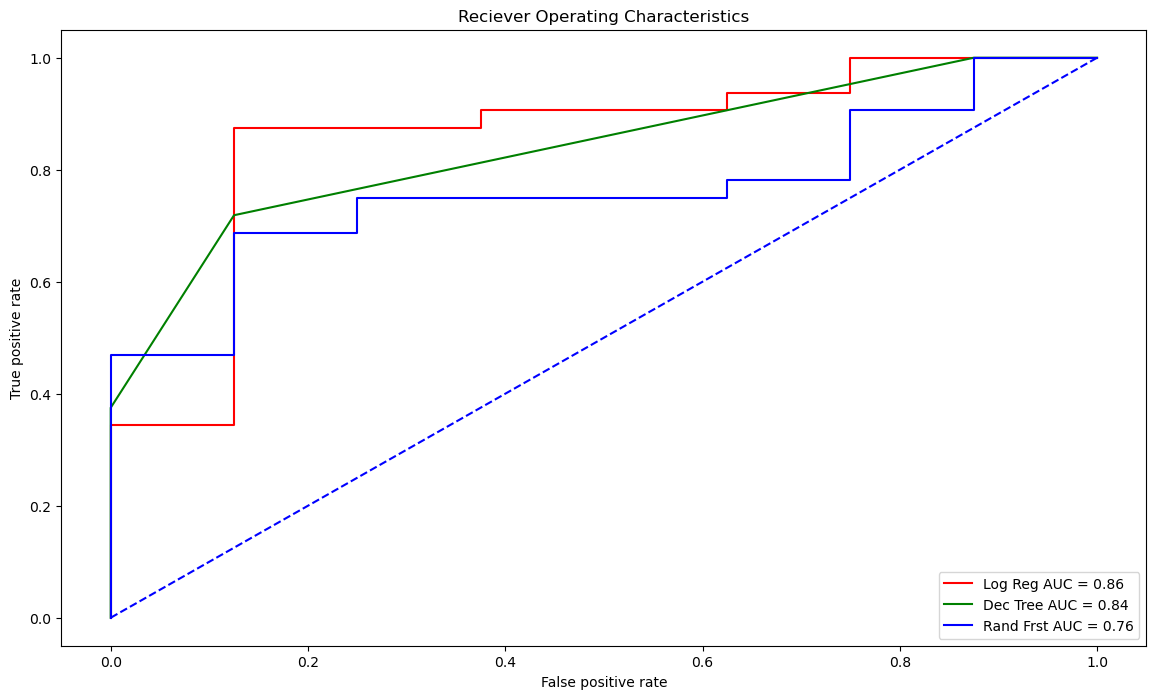

In [29]:
proba_lr = keep_best_reg.predict_proba(x_test)[:,1]
proba_dt = keep_best_tree.predict_proba(x_test)[:,1]
proba_rf = keep_best_forest.predict_proba(x_test)[:,1]
fpr_lr,tpr_lr, threshold_lr = roc_curve(y_test,proba_lr)
fpr_dt,tpr_dt, threshold_dt = roc_curve(y_test,proba_dt)
fpr_rf,tpr_rf, threshold_rf = roc_curve(y_test,proba_rf)
roc_auc_lr = auc(fpr_lr,tpr_lr)
roc_auc_dt = auc(fpr_dt,tpr_dt)
roc_auc_rf = auc(fpr_rf,tpr_rf)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Characteristics')
plt.plot(fpr_lr,tpr_lr,'r',label = 'Log Reg AUC = %0.2f' % roc_auc_lr)
plt.plot(fpr_dt,tpr_dt,'g',label = 'Dec Tree AUC = %0.2f' % roc_auc_dt)
plt.plot(fpr_rf,tpr_rf,'b',label = 'Rand Frst AUC = %0.2f' % roc_auc_rf)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [30]:
print('Log Reg Class Report:')
print(classification_report(y_test,keep_best_reg.predict(x_test)))
print('Decision Tree Class Report:')
print(classification_report(y_test,keep_best_tree.predict(x_test)))
print('Rand Forest Class Report:')
print(classification_report(y_test,keep_best_forest.predict(x_test)))

Log Reg Class Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.84      1.00      0.91        32

    accuracy                           0.85        40
   macro avg       0.92      0.62      0.66        40
weighted avg       0.87      0.85      0.81        40

Decision Tree Class Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.82      1.00      0.90        32

    accuracy                           0.82        40
   macro avg       0.91      0.56      0.56        40
weighted avg       0.86      0.82      0.77        40

Rand Forest Class Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.82      1.00      0.90        32

    accuracy                           0.82        40
   macro avg       0.91      0.56      0.56        4

Based on the above, we can see that the rates for Decision Tree and Random Forest models perform worse than the Logistic Regression Model. One explanation for this case is due to weakness of tree based methods on unbalanced data. The imbalance can be seen in the EDA section of this notebook where there have been more survivors than non survivors. The ROC curve shows a curve where the best trade off between the True Positive Rate and False Positive Rate can lie, i.e. a threshold value. <br>

More data is generally better to train models with as a small amount of sample data is difficult to represent an entire population. A better observation can be made and further transformations can then be made to the predictor variables such as log transformations if the data is right skewed or exponentials if the data is left skewed.

Other methods that could possibly improve the model includes a feature selection step. Such as forward stepwise or backward stepwise selection method could provide a better output of the model as some of features may be redundant and cause a reduction in the output metrics instead. Other models could be looked into as an option to further improve the results of the models such as Support Vector Machines, XGBoost (where the package has an inbuilt feature importance) or more complicated models such as Neural Networks.

### References

[1] https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you <br>
[2] https://www.nia.nih.gov/health/high-blood-pressure-and-older-adults